# Technical Report - Best of the Best: Choosing the 'Best of' from 'Legal Advice'

## Phase 0:  Imports

In [1]:
import requests
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import nltk
import spacy
import en_core_web_sm

from datetime import datetime
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from langdetect import detect

## Phase 1 - Problem Definition

###    1.1 Broad Goal(s):

    My goal is two-fold:
        1. Using [Pushshift's](https://github.com/pushshift/api) API, collect posts from two subreddits of my choosing.
        2. Use NLP to train a classifier on which subreddit a given post came from. This is a binary classification problem.

###    1.2 Subreddit Selection

Reddit.com has a 'best of' feature-- both of Reddit itself and of specific subreddits.  How a post or comment is selected to be a 'best of' is a fascinating rabbit hole to dig in to- see a guest post by Randall Munroe of XKCD fame on the subject here: 
    https://redditblog.com/2009/10/15/reddits-new-comment-sorting-system/
    or take a look at the reddit post asking the same question here:
    https://www.reddit.com/r/NoStupidQuestions/comments/6cmz29/how_does_reddit_determine_the_best_ranking_in_a/

TL;DR- it combines a statistical algorithm that tracks the activity, number of comments and number of upvotes to determine which comments and which posts are the most engaged with and flags it for a redditor's review.

The question I wanted to examine is whether or not the titles can be parsed to determine whether they come from the original subreddit or from the 'best of' subreddit *in the same category.*
    
To do this I'm looking at the subreddits of:

    1. r/legaladvice
    2. r/bestoflegaladvice

In short: can we build a model that will predict whether a post is from the legal advice subreddit or the curated best of legal advice subreddit?

### 1.3 Problem Statement

How well can we train a classification model to correctly classify the title of a subreddit post as belonging to the r/legaladvice subreddit or the r/bestoflegaladvice subreddt?

Stretch question:  Predict which r/legaladvice posts are most likely to be added to r/bestoflegaladvice?

# Phase 2 - Data Gathering

### 2.1 Define Function to gather posts from reddit using pushshift API

In [2]:
def get_posts(subreddit, n):
    url = 'https://api.pushshift.io/reddit/search/submission'
    if n < 100:
        params = {
        'subreddit' : subreddit, 
        'size': n 
        }
        res = requests.get(url, params)
        data = res.json()
        posts = data['data']
    else:
# note:  Pushshift.io now has a hard limit of 100 posts returned per API hit, so I'm setting this 100 limit here and will loop through this call until I hit n posts
        #get now in epoch date time format
        today = datetime.now()
        now = today.replace(hour=0, minute=0, second=0, microsecond=0)
        epoch = int(now.timestamp()) #get now in epoch date time format

        params = {
            'subreddit' : subreddit,
            'size' : 100, #pull 100 posts at a time
            'before' : epoch #set to now
        }
        posts = []
        # until I have as many posts as called for
        while len(posts) <  n:
            # get the posts
            res = requests.get(url, params)
            # convert to list
            data = res.json()
            # add to list
            posts.extend(data['data'])
            # set params 'before' to oldest post's utc
            params['before'] = data['data'][99]['created_utc']
            # pause for 5 seconds so we're not hitting the API too fast and maxing it out.
            time.sleep(5)

    return pd.DataFrame(posts) # 

### 2.2 Gather Posts from each of 2 Subreddits

        - r/bestoflegaladvice
        - r/legaladvice

First look used a total set of 2,000 titles, final model was trained on a total set of 10,000 title.

In [3]:
bola_df = get_posts('bestoflegaladvice', 5_000)
la_df = get_posts('legaladvice', 5_000)
#  get 'r/bestoflegaladvice' and 'r/legaladvice' separately, concat together
df = pd.concat([bola_df, la_df], ignore_index = True)

### 2.3 Data Cleaning

In this particular case there were no missing cells and significantly more columns than needed.  Data cleaning was completed by simply dropping all columns except the text corpus 'title' column and the target columns of 'subreddit'.  In future iterations, filtering the corpus by language may prove useful

In [4]:
df =  df[['title', 'subreddit']]

### 2.4 Save to CSV for EDA

In [5]:
df.to_csv('./data/clean_reddit_data.csv', index = False)

## Phase 3 - Exploratory Data Analysis
    3.1 VADER Sentiment Analysis
    3.2 Word Count/Length Analysis
    3.3 Pipeline/Grid Search 
    3.4 Title Tags?  y/n?
        - Best of has common title tags (ie. LAOP)
    3.4 save to CSV

In [6]:
#load in clean data
df = pd.read_csv('./data/clean_reddit_data.csv')

### 3.1 Sentiment Analysis

In [41]:
sia = SentimentIntensityAnalyzer()
# following C. Schmitt's sentiment analysis lesson for SIA workflow.
# https://git.generalassemb.ly/DSI-12-Echelon/nlp_modeling_and_sentiment_analysis

dicts = []

for title in df['title']:
    scores = sia.polarity_scores(title)
    dicts.append(scores)

scores = pd.DataFrame(dicts)

# add scores to existing df
sia_df = pd.concat([df, scores], axis = 1)


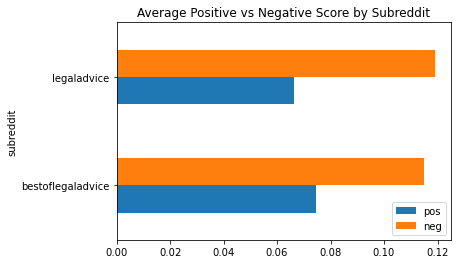

In [8]:
sia_df.groupby('subreddit').mean()[['pos', 'neg']].plot(kind = 'barh')
plt.title('Average Positive vs Negative Score by Subreddit')
plt.savefig('./imgs/pos-neg-avg.png');

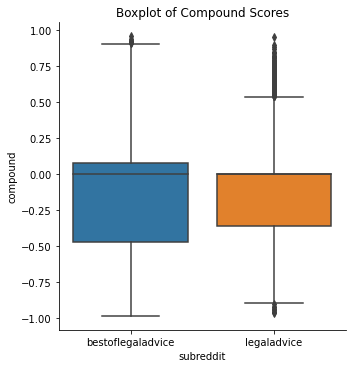

In [9]:
sns.catplot(x='subreddit', y='compound', kind='box', data=sia_df)
plt.title('Boxplot of Compound Scores');
plt.savefig('./imgs/sia-compound-boxplot.png')

The compound scores are showing the biggest variation between the two categories.  We're seeing a wider spread of compound sentiment scores in the r/bestoflegaladvice subreddit.

## 3.2 Word Count / N-Gram Analysis

In [10]:
wc_df = sia_df.copy()

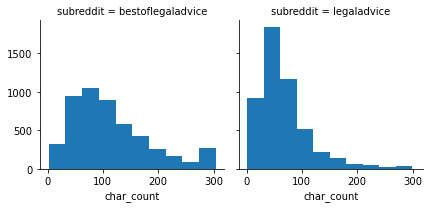

In [11]:
wc_df['char_count'] = wc_df['title'].map(len)
g = sns.FacetGrid(wc_df, col="subreddit")
g.map(plt.hist, "char_count")
g.add_legend();
plt.savefig('./imgs/char_count_comparison.png');

The overall length in characters of the r/bestoflegaladvice titles are showing a flatter curve and greater overall distribution than r/legaladvice, which is showing a positive skew.

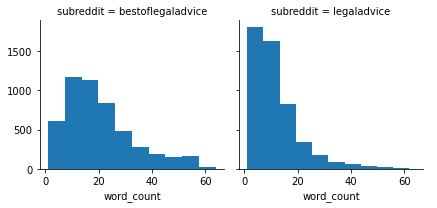

In [12]:
wc_df['word_count'] = [len(title.split(' ')) for title in wc_df['title']]
g = sns.FacetGrid(wc_df, col="subreddit")
g.map(plt.hist, "word_count")
g.add_legend()
plt.savefig('./imgs/word_count_comparison.png')

Unsurprisingly, we're seeing comparable distributions of words counts to character counts.

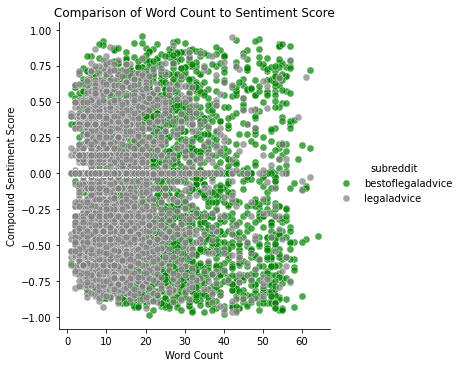

In [13]:
pal = dict(bestoflegaladvice="green", legaladvice="gray")
g = sns.FacetGrid(wc_df, hue="subreddit", palette=pal, height=5, )
g.map(plt.scatter, "word_count", "compound", s=50, alpha=.7, linewidth=.5, edgecolor="white")
plt.xlabel('Word Count')
plt.ylabel('Compound Sentiment Score')
plt.title('Comparison of Word Count to Sentiment Score')
g.add_legend();
plt.savefig('./imgs/word_count_vs_sentiment.png')

When looking at a scatterplot of compound sentiment score compared to word count by subreddit, we can see that the r/legaladvice subreddit' posts are clustered mostly on the smaller word count end and the r/bestoflegaladvice subreddit is spread out.  While we do not see a trend in the sentiment, we do see that the r/bestoflegaladvice subreddit's titles tend to have more words

The following section uses functions created by Susan Li, available at her Towards Data Science post on NLP EDA
https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a

In [14]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [15]:
common_words = get_top_n_words(wc_df['title'], 20)
cw_df = pd.DataFrame(common_words, columns = ['Word', 'Count'])
cw_df[:20]

,Word,Count
0,laop,2772
1,car,561
2,legal,513
3,la,487
4,wants,458
5,landlord,422
6,title,401
7,advice,382
8,house,374
9,help,358


In [16]:
def get_top_n_bigrams(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english', ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [17]:
common_bigrams = get_top_n_bigrams(wc_df['title'], 20)
la_wc_df = wc_df[wc_df['subreddit'] == 'legaladvice'].copy()
bola_wc_df = wc_df[wc_df['subreddit'] == 'bestoflegaladvice'].copy()
la_common_bigrams = get_top_n_bigrams(la_wc_df['title'], 20)
bola_common_bigrams = get_top_n_bigrams(bola_wc_df['title'], 20)

In [18]:
la_cb_df = pd.DataFrame(la_common_bigrams, columns = ['Bigram', 'Count'])
la_cb_df

,Bigram,Count
0,need help,41
1,need advice,41
2,security deposit,39
3,child support,34
4,car accident,33
5,covid 19,31
6,year old,29
7,apartment complex,27
8,speeding ticket,26
9,new york,23


In [19]:
bola_cb_df = pd.DataFrame(bola_common_bigrams, columns = ['Bigram', 'Count'])
bola_cb_df

,Bigram,Count
0,actual title,293
1,laop wants,125
2,year old,92
3,wants know,70
4,legal advice,66
5,tree law,41
6,la discusses,39
7,laop ex,37
8,good advice,37
9,laop gets,36


All right!  We're seeing significant divergence here in the most common bigrams across the two subreddits.  This is promising for training a good model.  Additionally, we're seeing that the most common bigrams from r/bestoflegaladvice are much more common than r/legaladvice.  That being said, I'm seeing a very common tag popping up-  'LAOP'  In the context of r/bestoflegaladvice, this means 'Legal Advice Original Post'.  Additionally, the most common bigram overall is 'actual title'.  

While these two points are highly useful in building a classifier based on title alone, they might get in the way of longer term goals of building a predictor of which posts in r/legaladvice will become r/bestoflegaladvice.

### 3.3 Spacy library - Part of Speech Analysis

Inspired to use the Spacy Library by TowardsDataScience's post by Edward Ma available at https://towardsdatascience.com/named-entity-recognition-3fad3f53c91e

In [20]:
# Spacy set up
nlp = en_core_web_sm.load()

In [21]:
pct_dicts = []
for title in df['title']:
    doc = nlp(title)
    typ_pcts = {
        'pct_nouns': (len([token.text for token in doc if token.pos_ == 'NOUN'])/ len(doc)),
        'pct_verbs' : (len([token.text for token in doc if token.pos_ == 'VERB'])/ len(doc)),
        'pct_propnouns' : (len([token.text for token in doc if token.pos_ == 'PROPN'])/ len(doc))
    }
    pct_dicts.append(typ_pcts)
    
pos_pcts = pd.DataFrame(pct_dicts)

typ_dicts = []
for title in df['title']:
    doc = nlp(title)
    typ_counts = {
        'n_nouns': len([token.text for token in doc if token.pos_ == 'NOUN']),
        'n_verbs' : len([token.text for token in doc if token.pos_ == 'VERB']),
        'n_propnouns' : len([token.text for token in doc if token.pos_ == 'PROPN'])
    }
    typ_dicts.append(typ_counts)
    
pos_counts = pd.DataFrame(typ_dicts)

In [22]:
ks_df = pd.concat([wc_df, pos_pcts, pos_counts], axis = 1) #Kitchen Sink Dataframe- it has everything in it.

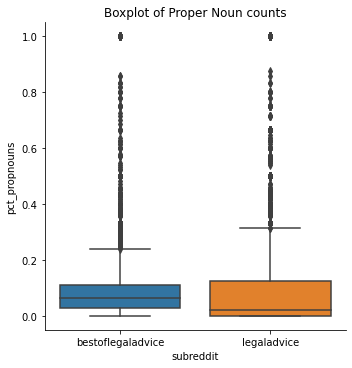

In [23]:
sns.catplot(x='subreddit', y='pct_propnouns', kind = 'box', data= ks_df)
plt.title('Boxplot of Proper Noun counts')
plt.savefig('./imgs/comparative_propnoun_counts.png');

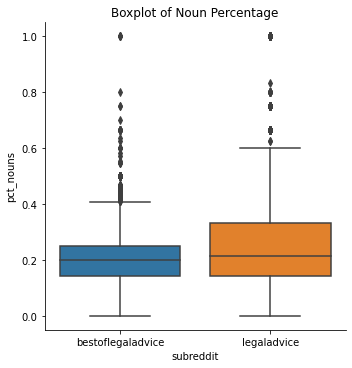

In [24]:
sns.catplot(x='subreddit', y='pct_nouns', kind = 'box', data=ks_df)
plt.title('Boxplot of Noun Percentage')
plt.savefig('./imgs/comparative_noun_counts.png');

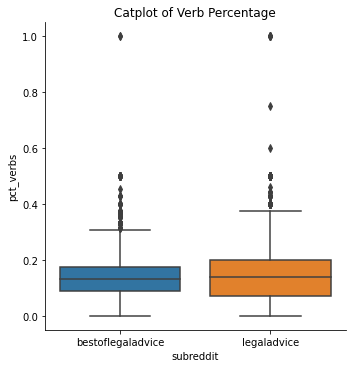

In [25]:
sns.catplot(x='subreddit', y='pct_verbs', kind = 'box', data=ks_df)
plt.title('Catplot of Verb Percentage');
plt.savefig('./imgs/comparative_verb_counts.png');

When plotting the percentage of part of speech type, I'm showing a few differences in spread between r/bestoflegaladvice and r/legaladvice.  Might be something to add in as an experiment for modeling the kitchen sink df in addition to a CountVectorized df or a TF-IDF Vectorized dataframe.  The documentation that is included with spaCy implies that it is good for training Neural Network models and it might be a bit of a stretch to include it in this project.

## Phase 4 - Modeling

In [26]:
base_df = pd.read_csv('./data/clean_reddit_data.csv')
# convert the base_df subreddit column to 1's and 0's
base_df['subreddit'] = base_df['subreddit'].map({'bestoflegaladvice': 1, 'legaladvice': 0})

### 4.1 Train/Test/Split

In [27]:
X = base_df['title']
y = base_df['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 9) # for the Mighty Nein!

The modeling notebook contains all of the models tested as well as annotations.  For the purposes of this summary we're bringing in only the best option- the Multinomial Naive Bayes

In [28]:
cvec_mnnb_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('mnnb', MultinomialNB())
])

cvec_mnnb_pipe_params = {
    'cvec__stop_words' : [None],
    'cvec__max_features' : [4000],# Maximum number of features fit: 2000, 3000, 4000, 5000
    'cvec__min_df' : [2],                 # Minimum number of documents needed to include token: 2, 3
    'cvec__max_df' : [.8],                # Maximum number of documents needed to include token: 80%, 90%, 95%
    'cvec__ngram_range' : [(1, 1),   # Check (individual tokens) and also check (individual tokens and 2-grams).
}
cvec_mnnb_gs = GridSearchCV(cvec_mnnb_pipe, cvec_mnnb_pipe_params, cv = 5, verbose = 1, n_jobs = -2)

cvec_mnnb_gs.fit(X_train, y_train)
cvec_mnnb_gs.score(X_train, y_train), cvec_mnnb_gs.score(X_test, y_test)

In [44]:
cvec_mnnb_gs.best_params_

{'cvec__max_df': 0.8,
 'cvec__max_features': 4000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None}

### 4.2-4.5 Different Model Types

See the modeling notebook for more detailed breakdown of models, a summary is below:

## Phase 5 - Model Analysis

In [30]:
accuracy_df = pd.read_csv('./data/accuracy_data.csv', index_col = 'Unnamed: 0')

In [31]:
accuracy_df

,Train,Test,Variance
Count Vectorized Logistic Regression,0.94,0.89,0.05
TF-IDF Logistic Regression,0.95,0.89,0.06
Count Vectorized K-Nearest Neighbors,0.99,0.72,0.27
TF-IDF Vectorized K-Nearest Neighbors,0.99,0.58,0.41
Count Vectorized Multinomial Naive Bayes,0.91,0.87,0.04
TF-IDF Vectorized Multinomial Naive Bayes,0.91,0.87,0.04
Count Vectorized Random Forest,0.91,0.88,0.03
TF-IDF Vectorized Random Forest,0.92,0.87,0.05


In [32]:
misclassified_titles = pd.read_csv('./data/misclassified_titles.csv')

In [33]:
cvec_mnnb_preds = cvec_mnnb_gs.predict(X_test)
prediction = pd.DataFrame(data = cvec_mnnb_preds, columns=['prediction'], index = X_test.index.copy())
product = pd.concat([X_test, prediction, y_test], axis = 1)
misclassifieds = product[product['subreddit'] != product['prediction']]
misclassifieds['language'] = misclassifieds['title'].map(detect)
false_positives = product[(product['subreddit'] != product['prediction']) & (product['prediction'] == 1)]
false_negatives = product[(product['subreddit'] != product['prediction']) & (product['prediction'] == 0)]

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [34]:
def get_top_n_bigrams(corpus, n=None): #using Susan Li's bigram function again
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [35]:
fp_common_bigrams = get_top_n_bigrams(false_positives['title'], 20)
fp_cb_df = pd.DataFrame(fp_common_bigrams, columns = ['Bigram', 'Count'])
fp_cb_df[:10]

,Bigram,Count
0,is it,7
1,it legal,5
2,they have,4
3,out of,4
4,for the,4
5,this is,4
6,to be,4
7,the first,3
8,my wife,3
9,legal for,3


In [36]:
fn_common_bigrams = get_top_n_bigrams(false_negatives['title'], 20)
fn_cb_df = pd.DataFrame(fn_common_bigrams, columns = ['Bigram', 'Count'])
fn_cb_df[:10]

,Bigram,Count
0,actual title,5
1,can get,5
2,want to,4
3,on the,4
4,it fraud,4
5,my ex,3
6,for the,3
7,what do,3
8,an asshole,3
9,in the,3


Looking at my miscalssified titles, I'm noticing we're not seeing any of the most common bigrams we encountered in EDA.  One of the limitations of using bigrams in this set of data is the manner in which the r/bestoflegaladvice titles are set.  During EDA I noted the top bigrams in this subset included specific tags such as 'Actual post' and 'LAOP ___' (Legal Advice Original Post).  While this allows for more effective classification models when using bigrams, I'm seeing that the tags are not included in the misclassified titles.  In other words, when the model is trained on bigrams that include these common tags, it is a less effective classifier when those tags are missing.

One other point that came up when examining the misclassified titles was that we found a number of posts whose titles were not in english, when our model is primarily looking at an dataset that is in English

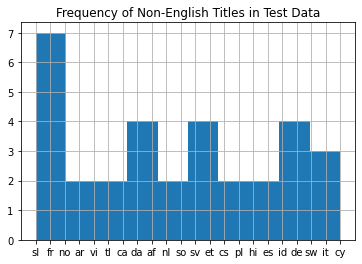

In [37]:
not_english = misclassifieds[misclassifieds['language'] != 'en']
not_english['language'].hist()
plt.title('Frequency of Non-English Titles in Test Data')
plt.savefig('./imgs/non-english-titles-hist.png');

In [38]:
not_english['title']

9853             Is it illegal to drive nude in nebraska?
8173                    question about Good Samaritan law
273                        Peter, Peter, Pumpkin stealer?
1554    إرهاب صهيونى.. جرافات الاحتلال تقطع جسد شاب فل...
523               Xe nâng phuy gắn cân điện tử mua ở đâu?
3194                                       Kangaroo Court
4892               "In capitalist Nevada, bank robs you!"
7611                                     Food stamp fraud
4917                                         bestof video
1020                                                 Help
3226    Uahahahhaaaaaaahahahahhahahaahahahahhahahahahh...
8285                                   Parking violations
6853                                  False PFA dismissed
6843                                          NFC problem
9993                                             Crazy ex
1232    #Who_Is_RealGod परमात्मा का नाम कबीर (कविर देव...
6238                                    deleted edu email
2151    Is it 

Although as a side note, of the test data titles identified using the langdetect library's built in tools, some of the titles are actually in English, so I would be hesitent to use langdetect's detect function as a data cleaning tool without a deeper understanding of its tools.

## Phase 6 - Conclusions 

### 6.0 Revisit Problem Statement

Original problem statement: How well can we train a classification model to correctly classify the title of a subreddit post as belonging to the r/legaladvice subreddit or the r/bestoflegaladvice subreddt?  Which classification model type will be the strongest?

In [39]:
accuracy_df.sort_values(by = ['Variance'])

,Train,Test,Variance
Count Vectorized Random Forest,0.91,0.88,0.03
Count Vectorized Multinomial Naive Bayes,0.91,0.87,0.04
TF-IDF Vectorized Multinomial Naive Bayes,0.91,0.87,0.04
Count Vectorized Logistic Regression,0.94,0.89,0.05
TF-IDF Vectorized Random Forest,0.92,0.87,0.05
TF-IDF Logistic Regression,0.95,0.89,0.06
Count Vectorized K-Nearest Neighbors,0.99,0.72,0.27
TF-IDF Vectorized K-Nearest Neighbors,0.99,0.58,0.41


Accuracy is a good score to use in this case as we have a 50/50 split and there is no particular reason to favor specificity or sensitivity instead of overall accuracy.

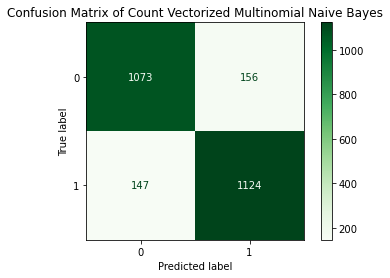

In [40]:
plot_confusion_matrix(cvec_mnnb_gs, X_test, y_test, cmap='Greens', values_format='d')
plt.title('Confusion Matrix of Count Vectorized Multinomial Naive Bayes');

### 6.1 Conclusion

The best model we encountered was a Count Vectorizer paired with a multinomial naive bayes model looking at bigrams.  As we predicted during EDA, we found that there was significant divergence between the most common bigrams of each subset, however as we looked at the misclassified data, we found that using these bigrams may be a crutch-  the portion of the misclassified did not include common tags that are commonly used by the redditors who rename the posts for r/bestoflegaladvice when tagging the post in the 'best of' subreddit.

This model is heartening as it was able to correctly classify 86% of the posts it had not seen before, significantly outperfoming our baseline of 50%.  It also revealed some significant room for improvement.

### 6.2 Recommendations for Further Research

The model as currently trained is a good proof of concept, and should research continue, can serve as a basis for additional insights.  

Future Iterations could include:

    1. gather data from the reddit text instead of the reddit title.  Changing the corpus used will allow the model to potentially predict which legal advice posts will become 'best of' and serve as a model that predicts popularity and engagement from content.
    2. strip out the crutch of title tags such as 'LAOP' to better tune the model.
    3. incorporate a sentiment analysis transformer in the pipeline
    4. train and incorporate a language filter to remove titles in a different language or potentially include this step as a transformer and add it as a feature to be examined.

### 6.3 Resources

Randall Munroe- Reddit's New Comment Sorting System
https://redditblog.com/2009/10/15/reddits-new-comment-sorting-system/ 

various redditors in r/NoStupidQuestions:
https://www.reddit.com/r/NoStupidQuestions/comments/6cmz29/how_does_reddit_determine_the_best_ranking_in_a/

Sentiment Analysis workflow in section 3.1 created by Caroline Schmitt- Sentiment Analysis lesson
https://git.generalassemb.ly/DSI-12-Echelon/nlp_modeling_and_sentiment_analysis


EDA Susan Li- Exploratory Data Analysis primer for text data:
https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a

Edward Ma - Named Entity Recognition roundup:
https://towardsdatascience.com/named-entity-recognition-3fad3f53c91e
